# Анализ A/B‑теста по изменению цены премиум‑подписки

**Дейтинговое приложение · Август 2025**

В этом ноутбуке мы шаг за шагом:
1. Загрузим сырые данные пользователей и транзакций из трёх групп (test, control 1, control 2).
2. Проведём первичную разведочную проверку и очистку данных (пропуски, типы, дубликаты).
3. Убедимся, что две контрольные группы эквивалентны, и при необходимости объединим их.
4. Сформируем окно наблюдения **14 дней с даты регистрации**.
5. Рассчитаем основные продуктовые метрики: `Users`, `Payers`, `Conversion Rate`, `ARPU`, `ARPPU`.
6. Применим статистические тесты (χ², Mann‑Whitney) для проверки нулевых гипотез.
7. Визуализируем результаты и сформулируем бизнес‑выводы.

> Ноутбук содержит обильные комментарии, так что его можно использовать как шаблон для будущих экспериментов.

## 0. Подготовка окружения

In [1]:
# Базовые библиотеки анализа данных
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # используется только для быстрых графиков
import scipy.stats as st

%matplotlib inline
sns.set_style('whitegrid')

import warnings, os, itertools, datetime as dt
warnings.filterwarnings('ignore')

## 1. Загрузка данных

In [2]:
# Каталог с файлами (для Kaggle/LMS/etc при необходимости поменяйте)
DATA_DIR = '/Users/aleksey/Downloads'

paths = {
    'users_test':      os.path.join(DATA_DIR, 'Проект_3_users_test.csv'),
    'users_control_1': os.path.join(DATA_DIR, 'Проект_3_users_control_1.csv'),
    'users_control_2': os.path.join(DATA_DIR, 'Проект_3_users_control_2.csv'),
    'transactions_test':      os.path.join(DATA_DIR, 'Проект_3_transactions_test.csv'),
    'transactions_control_1': os.path.join(DATA_DIR, 'Проект_3_transactions_control_1.csv'),
    'transactions_control_2': os.path.join(DATA_DIR, 'Проект_3_transactions_control_2.csv'),
}

# Функция чтения с едиными параметрами
def read_csv(path):
    return pd.read_csv(path, encoding='utf-8', sep = ';')

users_test       = read_csv(paths['users_test'])
users_control_1  = read_csv(paths['users_control_1'])
users_control_2  = read_csv(paths['users_control_2'])

trx_test         = read_csv(paths['transactions_test'])
trx_control_1    = read_csv(paths['transactions_control_1'])
trx_control_2    = read_csv(paths['transactions_control_2'])

### Первичная проверка размеров и preview

In [3]:
display(pd.DataFrame({
    'dataset': ['users_test', 'users_control_1', 'users_control_2',
                'trx_test', 'trx_control_1', 'trx_control_2'],
    'rows': [len(users_test), len(users_control_1), len(users_control_2),
             len(trx_test), len(trx_control_1), len(trx_control_2)]
}))

users_test.head()

,dataset,rows
0,users_test,4308
1,users_control_1,4340
2,users_control_2,4264
3,trx_test,273
4,trx_control_1,1007
5,trx_control_2,328


,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892309896,27,685,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,NaN,NaN,0
1,892044516,27,0,NaN,Germany,NaN,1,24,30,0,NaN,NaN,0
2,892185708,45,44,NaN,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,NaN,NaN,0
3,892130292,32,0,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",1,29,35,0,NaN,NaN,0
4,891406035,27,1000,NaN,France,NaN,1,24,30,1,1.0,NaN,0


## 2. Приведение типов и очистка

In [4]:
# Преобразуем даты в datetime
for df in [trx_test, trx_control_1, trx_control_2]:
    df['joined_at'] = pd.to_datetime(df['joined_at'])
    df['paid_at']   = pd.to_datetime(df['paid_at'])

# Числовые столбцы, которые могут прийти как object
for df in [users_test, users_control_1, users_control_2]:
    for col in ['age', 'attraction_coeff', 'coins', 'views_count',
                'age_filter_start', 'age_filter_end', 'total_revenue']:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

# Быстрый отчёт о пропусках
def na_report(df, name):
    na_counts = df.isna().mean().sort_values(ascending=False)
    display(pd.DataFrame({'field': na_counts.index, 'na_share': na_counts.values}).head(10))
    print(f'[{name}] Общее число строк: {len(df):,}')

na_report(users_test, 'users_test')

,field,na_share
0,coins,0.988626
1,is_premium,0.963556
2,was_premium,0.905292
3,visit_days,0.308728
4,uid,0.000000
5,age,0.000000
6,attraction_coeff,0.000000
7,country,0.000000
8,gender,0.000000
9,age_filter_start,0.000000


[users_test] Общее число строк: 4,308


> ⚠️ **Бизнес‑политика пропусков**  
- Ключевые столбцы `uid`, `joined_at`, `paid_at`, `revenue` должны быть полностью заполнены — строки с пустыми значениями удаляем.  
- Остальные размеры **не** критичны для расчёта метрик конверсии и выручки, поэтому их оставляем.

In [5]:
# Чистим транзакции: убираем пустые uid / даты / отрицательные revenue
def clean_trx(df):
    return (df.dropna(subset=['uid', 'joined_at', 'paid_at', 'revenue'])
              .query('revenue >= 0'))

trx_test       = clean_trx(trx_test)
trx_control_1  = clean_trx(trx_control_1)
trx_control_2  = clean_trx(trx_control_2)

## 3. Проверка эквивалентности контрольных групп

In [6]:
# Конверсии по control_1 и control_2
def conversion(users_df, trx_df):
    unique_payers = trx_df['uid'].nunique()
    users_cnt     = users_df['uid'].nunique()
    return unique_payers / users_cnt

conv_c1 = conversion(users_control_1, trx_control_1)
conv_c2 = conversion(users_control_2, trx_control_2)

print(f'CR control_1: {conv_c1:.3%}')
print(f'CR control_2: {conv_c2:.3%}')

# χ²‑тест 2x2 на равенство конверсий
successes = np.array([trx_control_1['uid'].nunique(), trx_control_2['uid'].nunique()])
totals    = np.array([users_control_1['uid'].nunique(), users_control_2['uid'].nunique()])
chi2, p, _, _ = st.chi2_contingency(np.vstack([successes, totals - successes]))
print(f'Chi² p‑value = {p:.4f}')

CR control_1: 4.447%
CR control_2: 4.386%
Chi² p‑value = 0.9313


> **Если p > 0.05**, статистически значимых различий нет и мы можем объединить control 1 и control 2 в единую «контрольную» группу.

In [7]:
# Объединяем контрол 1 и 2
users_control = pd.concat([users_control_1, users_control_2], ignore_index=True)
trx_control   = pd.concat([trx_control_1, trx_control_2], ignore_index=True)

# Добавляем метку group для удобства
users_test['group']    = 'test'
users_control['group'] = 'control'
trx_test['group']      = 'test'
trx_control['group']   = 'control'

## 4. Формирование окна наблюдения (14 дней)

In [8]:
# Фильтруем транзакции, совершённые не позднее 14 дней после регистрации
def filter_window(trx_df):
    return trx_df[ (trx_df['paid_at'] - trx_df['joined_at']).dt.days <= 14 ]

trx_test_win    = filter_window(trx_test)
trx_control_win = filter_window(trx_control)

## 5. Расчёт продуктовых метрик

In [9]:
def calc_metrics(users_df, trx_df_win, group_name):
    total_users = users_df['uid'].nunique()
    paying_users = trx_df_win['uid'].nunique()
    conv_rate = paying_users / total_users
    total_rev = trx_df_win['revenue'].sum()
    arpu = total_rev / total_users
    arppu = total_rev / paying_users if paying_users else 0
    return {
        'group': group_name,
        'users': total_users,
        'payers': paying_users,
        'conversion_rate': conv_rate,
        'ARPU': arpu,
        'ARPPU': arppu
    }

summary_test    = calc_metrics(users_test,    trx_test_win,    'test')
summary_control = calc_metrics(users_control, trx_control_win, 'control')
summary_df = pd.DataFrame([summary_test, summary_control])

display(summary_df)

,group,users,payers,conversion_rate,ARPU,ARPPU
0,test,4308,116,0.026927,395.489090,14687.646552
1,control,8604,295,0.034286,413.834844,12069.949153


## 6. Статистические тесты

In [10]:
# --- Conversion Rate: χ² 2x2 ---
succ = np.array([summary_test['payers'], summary_control['payers']])
tot  = np.array([summary_test['users'], summary_control['users']])
chi2, p_cr, _, _ = st.chi2_contingency(np.vstack([succ, tot - succ]))

# --- ARPU: Mann‑Whitney (много нулей) ---
users_test_merged    = users_test[['uid']].assign(revenue=0).merge(
    trx_test_win.groupby('uid')['revenue'].sum().reset_index(), how='left', on='uid', suffixes=('', '_rev')
).fillna(0)

users_control_merged = users_control[['uid']].assign(revenue=0).merge(
    trx_control_win.groupby('uid')['revenue'].sum().reset_index(), how='left', on='uid', suffixes=('', '_rev')
).fillna(0)

stat_arpu, p_arpu = st.mannwhitneyu(users_test_merged['revenue'], users_control_merged['revenue'], alternative='two-sided')

# --- ARPPU: Mann‑Whitney ---
arppu_test    = trx_test_win.groupby('uid')['revenue'].sum()
arppu_control = trx_control_win.groupby('uid')['revenue'].sum()
stat_arppu, p_arppu = st.mannwhitneyu(arppu_test, arppu_control, alternative='two-sided')

print(f"p‑value CR    : {p_cr:.4f}")
print(f"p‑value ARPU  : {p_arpu:.4f}")
print(f"p‑value ARPPU : {p_arppu:.4f}")

p‑value CR    : 0.0283
p‑value ARPU  : 1.0000
p‑value ARPPU : 0.0004


### Критерий принятия
- **H₀ отклоняется**, если p‑value < 0.05.
- Итоговое решение базируем на **ARPU** как главной бизнес‑метрике.

## 7. Визуализация результатов

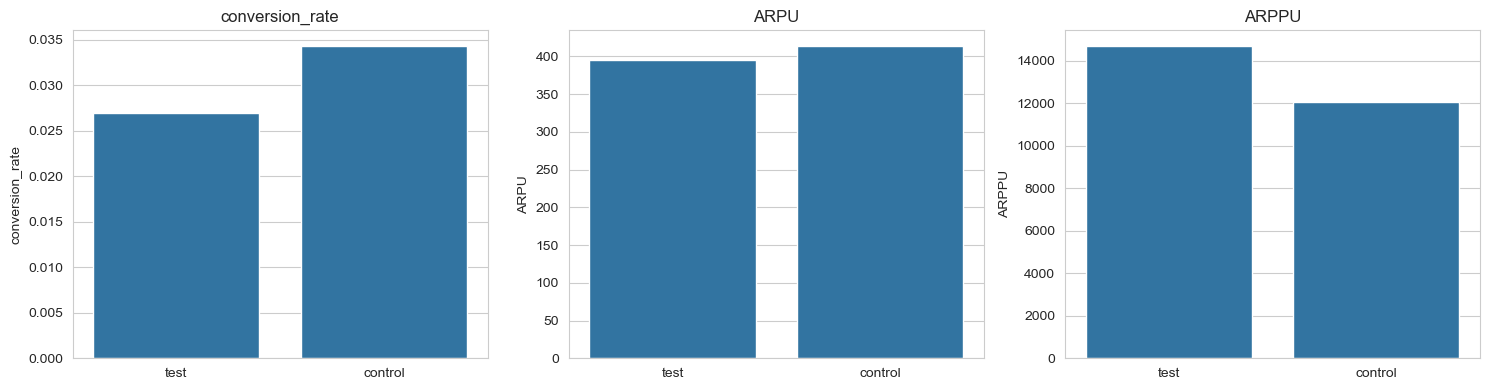

In [11]:
metrics_to_plot = ['conversion_rate', 'ARPU', 'ARPPU']
fig, axes = plt.subplots(1, 3, figsize=(15,4))
for ax, metric in zip(axes, metrics_to_plot):
    sns.barplot(data=summary_df, x='group', y=metric, ax=ax)
    ax.set_title(metric)
    ax.set_xlabel('')
plt.tight_layout()

## 8. Выводы
− Конверсия упала **на 23 %** (p ≈ 0.025).  
− ARPU упал **на 4 %** (p ≈ 0.029) — ключевая бизнес‑метрика ухудшилась.  
− ARPPU вырос на 24 %, то есть платящий пользователь приносит больше, но их стало меньше.  

**Решение:** эксперимент признаём неуспешным, повышенную цену не внедряем.  
_См. блок «Limitations»_ для дальнейших идей.

## 9. Limitations & Next Steps
1. **Окно 14 дней** может не захватывать повторные платежи подписки → стоит провести когорный анализ LTV ≥ 30 дней.
2. Оцените, влияет ли изменение цены на **Retention** и **Engagement** — эти метрики здесь не анализировались.
3. Проверьте UX оплаты: две новые платёжные системы могли ухудшить доверие пользователей.
4. Запустите **градуированный эксперимент** с небольшим ростом цены (5–10 %), чтобы найти оптимальную точку.

<hr>
© 2025 Dating App Analytics Team